# Задача бинарной классификации пола по характеристикам записей голосов
[Kaggle](https://www.kaggle.com/datasets/primaryobjects/voicegender)

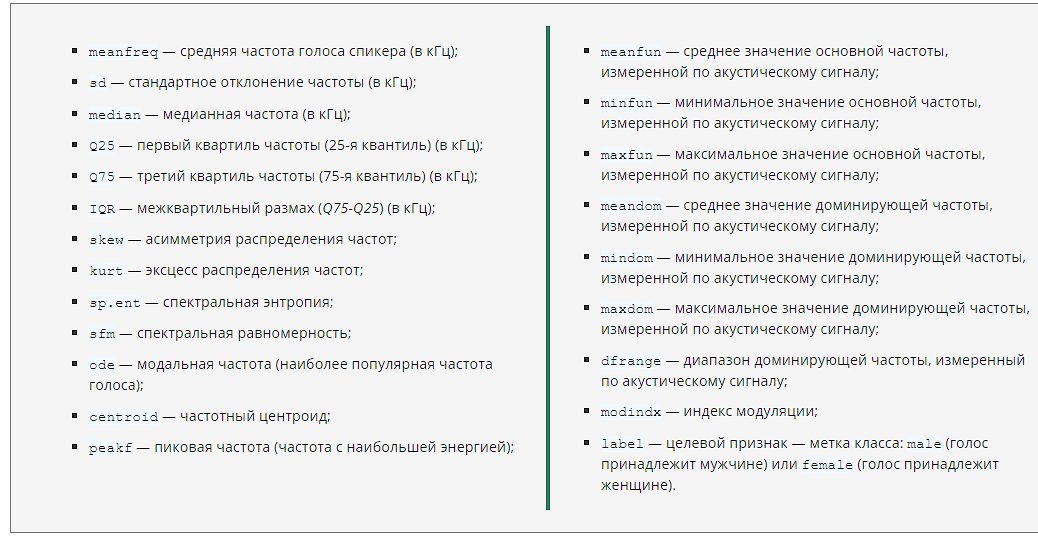

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output='pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

In [2]:
voice_data = pd.read_csv('data/voice_gender.zip')
TARGET = 'label'
voice_data

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [3]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [4]:
voice_data[TARGET].value_counts()

label
male      1584
female    1584
Name: count, dtype: int64

Классы целевого признака взвешены

In [5]:
X, y = voice_data.drop(columns=TARGET), voice_data[TARGET]

In [6]:
# sns.pairplot(voice_data.drop(columns='label'));

In [7]:
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


### Задание 7.1
Начнём с решающего пня.

Создайте модель дерева решений максимальной глубины 1. 

В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

In [8]:
dt1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
dt1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

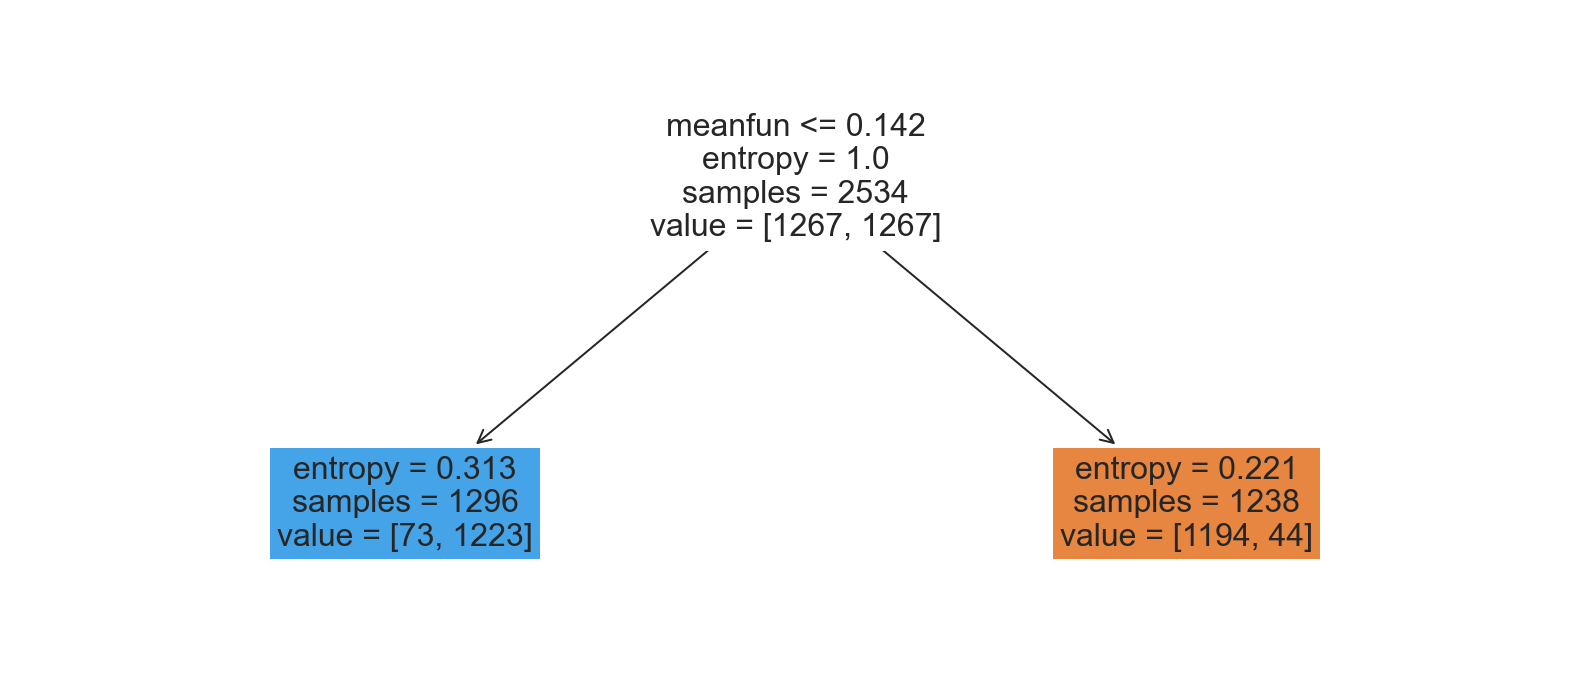

In [9]:
fig = plt.figure(figsize=(14, 6))
tree.plot_tree(
    decision_tree=dt1, # дерево решений 
    feature_names=X.columns, # имена факторов
    filled=True, # расцветка
    impurity=True, # отображать ли неоднородность в вершинах
    fontsize=16
);

In [10]:
in_node = dt1.tree_.n_node_samples[0]

# Identify the leaf nodes
is_leaf = np.where(dt1.tree_.children_left == -1)[0]
# Get the number of samples at each leaf node
samples_in_leaves = dt1.tree_.n_node_samples[is_leaf]

in_zero_leaf = samples_in_leaves[0]

In [11]:
print(f'{in_zero_leaf / in_node * 100:.1f}% наблюдений, для которых выполняется заданное в корневой вершине условие, содержится в обучающей выборке.')

51.1% наблюдений, для которых выполняется заданное в корневой вершине условие, содержится в обучающей выборке.


In [12]:
y_test_pred = dt1.predict(X_test)
print(f'Accuracy on test: {metrics.accuracy_score(y_test, y_test_pred):.3f}')

Accuracy on test: 0.956


### Задание 7.2

Увеличим глубину дерева.

Создайте дерево решений с максимальной глубиной 2. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

In [13]:
dt2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

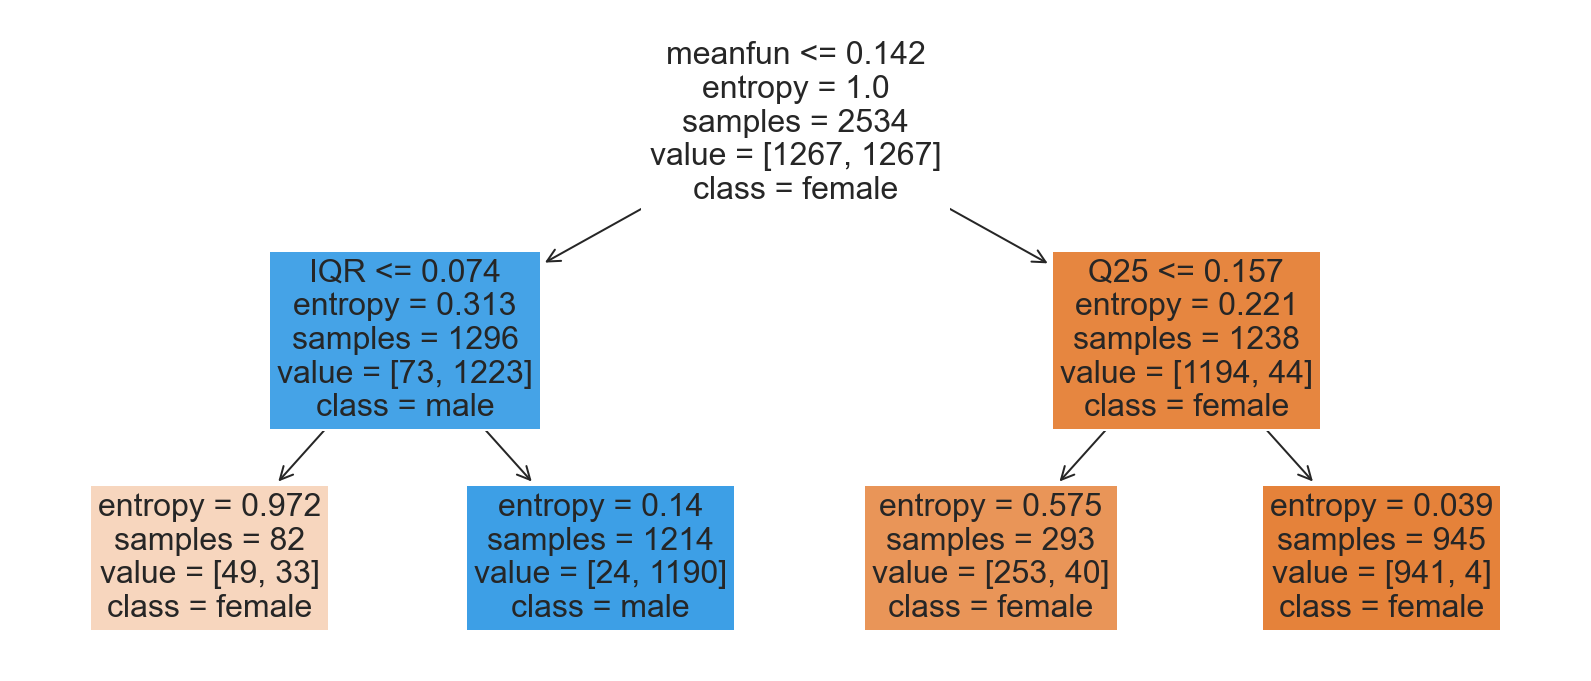

In [14]:
fig = plt.figure(figsize=(14, 6))
tree.plot_tree(
    decision_tree=dt2, # дерево решений 
    feature_names=X.columns, # имена факторов
    filled=True, # расцветка
    impurity=True, # отображать ли неоднородность в вершинах
    fontsize=16,
    class_names=dt2.classes_ # визуализация имен классов
);

In [15]:
y_test_pred = dt2.predict(X_test)
print(f'Accuracy on test: {metrics.accuracy_score(y_test, y_test_pred):.3f}')

Accuracy on test: 0.962


### Задание 7.3

Давайте дадим дереву решений полную свободу.

Создайте дерево решений, не ограничивая его максимальную глубину. В качестве критерия информативности используйте энтропию Шеннона.

В качестве значения параметра random_state возьмите 0.

Обучите модель на тренировочной выборке.

In [16]:
dt_full = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
dt_full.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [17]:
dt_full.get_depth()

12

In [18]:
dt_full.get_n_leaves()

54

In [19]:
y_train_pred = dt_full.predict(X_train)
y_test_pred = dt_full.predict(X_test)

print(f'Accuracy on train: {metrics.accuracy_score(y_train, y_train_pred):.3f}')
print(f'Accuracy on test: {metrics.accuracy_score(y_test, y_test_pred):.3f}')

Accuracy on train: 1.000
Accuracy on test: 0.973


### Задание 7.4

Давайте попробуем найти оптимальные внешние параметры модели дерева решений для поставленной задачи. 

Воспользуемся классическим методом подбора гиперпараметров — перебором на сетке с кросс-валидацией (Grid SearchCV).

In [20]:
# нужно перекодировать целевой признак, а то там famale/male. GridSearchCV ругается.
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [21]:
# Задаём сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], # критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], # максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] # минимальное количество объектов, необходимое для сплита
}

In [22]:
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0), 
    param_grid=param_grid,
    cv=model_selection.StratifiedKFold(n_splits=5),
    n_jobs=-1,
    scoring='accuracy'
)  

%time grid_search.fit(X_train, y_train_encoded)

CPU times: total: 188 ms
Wall time: 3.73 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [3, 4, 5, 10]},
             scoring='accuracy')

In [23]:
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train_encoded, y_train_pred):.3f}')
print(f'recision_score на train наборе: {metrics.precision_score(y_train_encoded, y_train_pred):.3f}')
print(f'recall_score на train наборе: {metrics.recall_score(y_train_encoded, y_train_pred):.3f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train_encoded, y_train_pred):.3f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test_encoded, y_test_pred):.3f}')
print(f'recision_score на train наборе: {metrics.precision_score(y_test_encoded, y_test_pred):.3f}')
print(f'recall_score на train наборе: {metrics.recall_score(y_test_encoded, y_test_pred):.3f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test_encoded, y_test_pred):.3f}')
print()
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

accuracy_score на train наборе: 0.996
recision_score на train наборе: 0.998
recall_score на train наборе: 0.993
f1_score на train наборе: 0.996

accuracy_score на test наборе: 0.970
recision_score на train наборе: 0.969
recall_score на train наборе: 0.972
f1_score на test наборе: 0.970

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}


### Задание 7.5

Для оптимального дерева решений, построенного в задании 7.4, найдите важность каждого из факторов. Визуализируйте её в виде столбчатой диаграммы.

Выделите топ-3 наиболее важных факторов, участвующих в построении дерева решений:

In [24]:
fi = pd.DataFrame({'importance': grid_search.best_estimator_.feature_importances_}, index=X.columns) * 100
fi = fi.sort_values(by='importance', ascending=False).iloc[:3,:]
fi

,importance
meanfun,86.134736
IQR,5.681024
sfm,1.800429


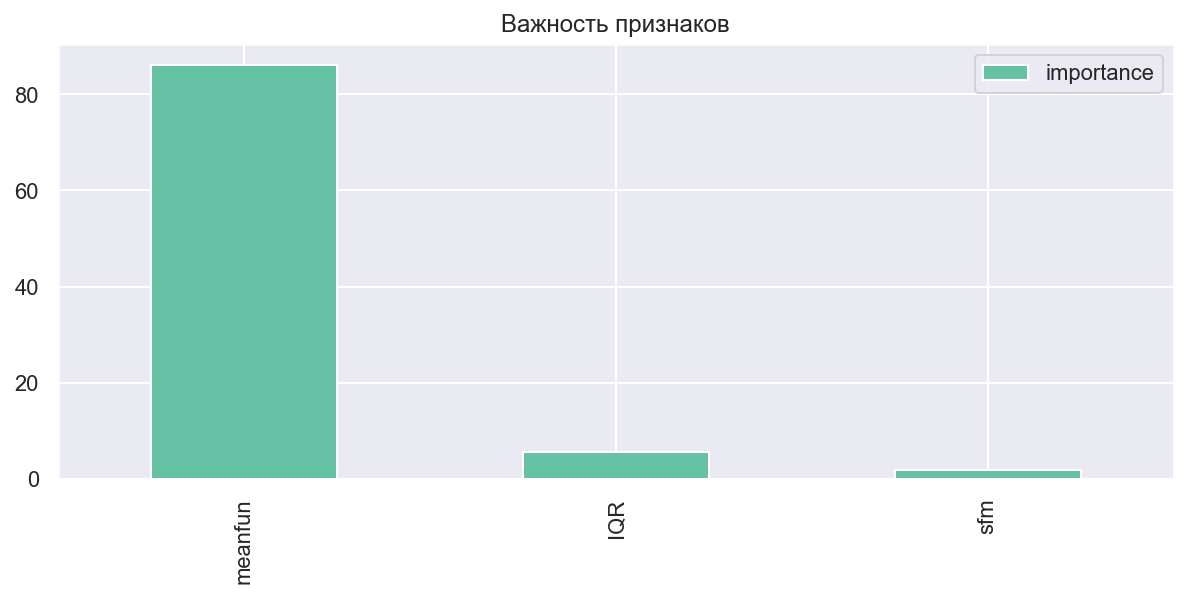

In [25]:
fi.plot(kind='bar', figsize=(10, 4), title='Важность признаков');